### Importing libraries

In [34]:
from logging import warning
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

### Loading data

In [35]:
data = pd.read_csv("train.csv", on_bad_lines='skip')

In [36]:
# Remove data with extreme outlier coordinates or negative fares
data = data.query('pickup_latitude > 40.7 and pickup_latitude < 40.8 and ' +
                  'dropoff_latitude > 40.7 and dropoff_latitude < 40.8 and ' +
                  'pickup_longitude > -74 and pickup_longitude < -73.9 and ' +
                  'dropoff_longitude > -74 and dropoff_longitude < -73.9 and ' +
                  'fare_amount > 0'
                  )
Y = data.fare_amount

In [37]:
base_features = ['pickup_longitude',
                 'pickup_latitude',
                 'dropoff_longitude',
                 'dropoff_latitude',
                 'passenger_count']

In [38]:
X = data[base_features]

In [39]:
X_train, X_val, y_train, y_val = train_test_split(X,Y, random_state=0)

In [40]:
model_1 = RandomForestRegressor(n_estimators=50, random_state=0).fit(X_train, y_train)

In [41]:
print("Data Sample:")
data.head()

Data Sample:


,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2.0
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1.0
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1.0
6,2012-11-20 20:35:00.0000001,7.5,2012-11-20 20:35:00 UTC,-73.980002,40.751662,-73.973802,40.764842,1.0
7,2012-01-04 17:22:00.00000081,16.5,2012-01-04 17:22:00 UTC,-73.951300,40.774138,-73.990095,40.751048,1.0


In [42]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
pickup_longitude,37876.0,-73.976833,0.014581,-73.999999,-73.987953,-73.979652,-73.967833,-73.900123
pickup_latitude,37876.0,40.756951,0.018116,40.700013,40.744994,40.758024,40.769600,40.799952
dropoff_longitude,37876.0,-73.975340,0.015944,-73.999999,-73.987110,-73.978596,-73.966460,-73.900292
dropoff_latitude,37876.0,40.757482,0.018692,40.700020,40.745956,40.758588,40.770441,40.799999
passenger_count,37876.0,1.655428,1.283415,0.000000,1.000000,1.000000,2.000000,6.000000


In [43]:

y_train.describe().T

count    37876.000000
mean         8.501644
std          4.613624
min          0.010000
25%          5.500000
50%          7.500000
75%         10.100000
max        128.610000
Name: fare_amount, dtype: float64

## Permutation importance

In [44]:
!pip install eli5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [45]:
import eli5

In [46]:
from eli5.sklearn import PermutationImportance

In [47]:
perm = PermutationImportance(model_1, random_state=0).fit(X_val, y_val)

In [48]:
eli5.show_weights(perm, feature_names = base_features)

Weight,Feature
0.9947 ± 0.0209,pickup_latitude
0.9842 ± 0.0283,dropoff_latitude
0.6548 ± 0.0157,pickup_longitude
0.6517 ± 0.0230,dropoff_longitude
0.0078 ± 0.0098,passenger_count


In [49]:
data['abs_lon_change'] = abs(data.dropoff_longitude - data.pickup_longitude)
data['abs_lat_change'] = abs(data.dropoff_latitude - data.pickup_latitude)

features_2  = ['pickup_longitude',
               'pickup_latitude',
               'dropoff_longitude',
               'dropoff_latitude',
               'abs_lat_change',
               'abs_lon_change']


In [50]:
X = data[features_2]
new_train_X, new_val_X, new_train_y, new_val_y = train_test_split(X, Y, random_state=1)
second_model = RandomForestRegressor(n_estimators=30, random_state=1).fit(new_train_X, new_train_y)

# Create a PermutationImportance object on second_model and fit it to new_val_X and new_val_y
perm2 = PermutationImportance(second_model, random_state=1).fit(new_val_X, new_val_y)

# show the weights for the permutation importance you just calculated
eli5.show_weights(perm2, feature_names = features_2)

Weight,Feature
0.7619 ± 0.0314,abs_lat_change
0.6310 ± 0.0284,abs_lon_change
0.1492 ± 0.0090,dropoff_latitude
0.1415 ± 0.0140,dropoff_longitude
0.1332 ± 0.0137,pickup_longitude
0.1083 ± 0.0163,pickup_latitude


**Partial Dependence:**
Partial dependence shows how a particular feature affects the prediction.
By making all other features constant, we want to find out how the feature in question influences our outcome. 

In [51]:
!pip install pdpbox

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [52]:
import matplotlib.pyplot as plt
from pdpbox import pdp, get_dataset, info_plots

In [53]:
feature_name = "pickup_longitude"

(<Figure size 1080x684 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fcf9259d090>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fcf92f97dd0>})

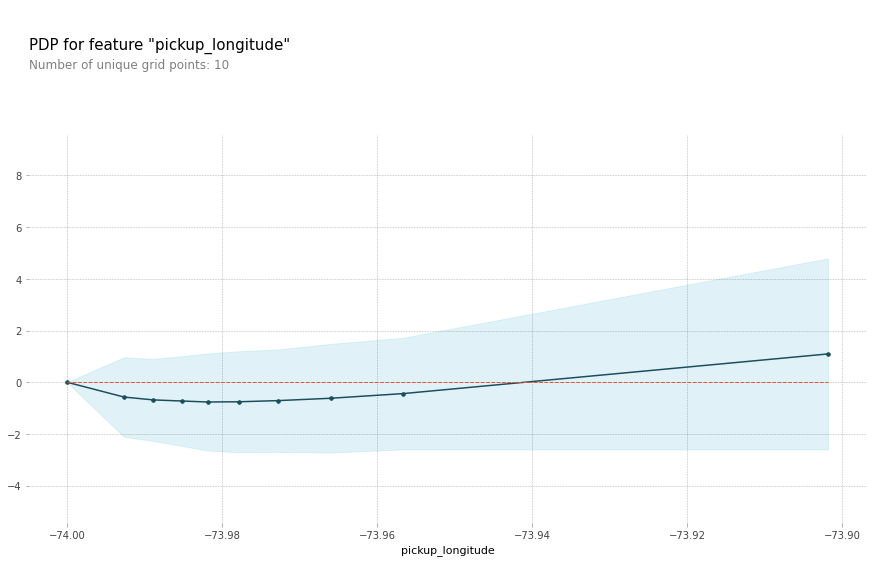

In [54]:
pdp_dist = pdp.pdp_isolate(model=second_model, dataset=new_val_X, model_features=features_2, feature=feature_name)

pdp.pdp_plot(pdp_dist, feature_name)

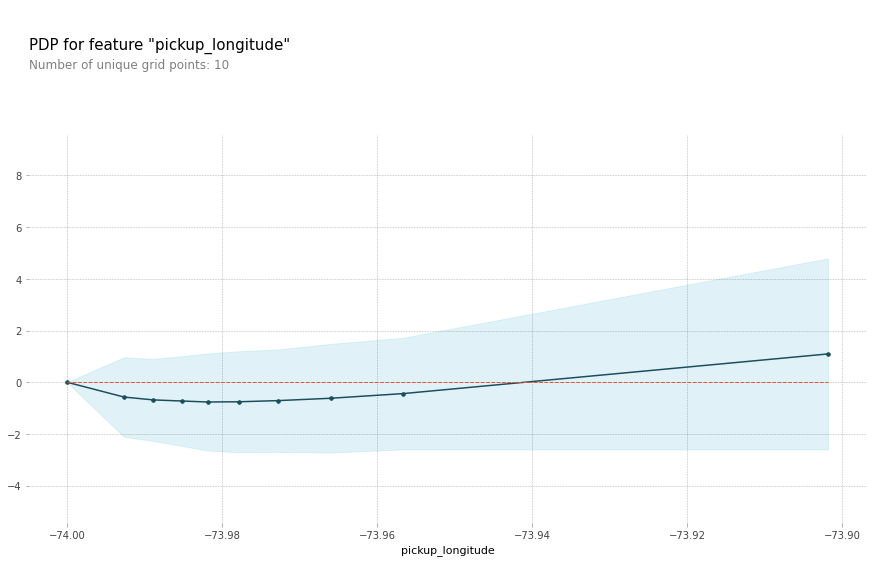

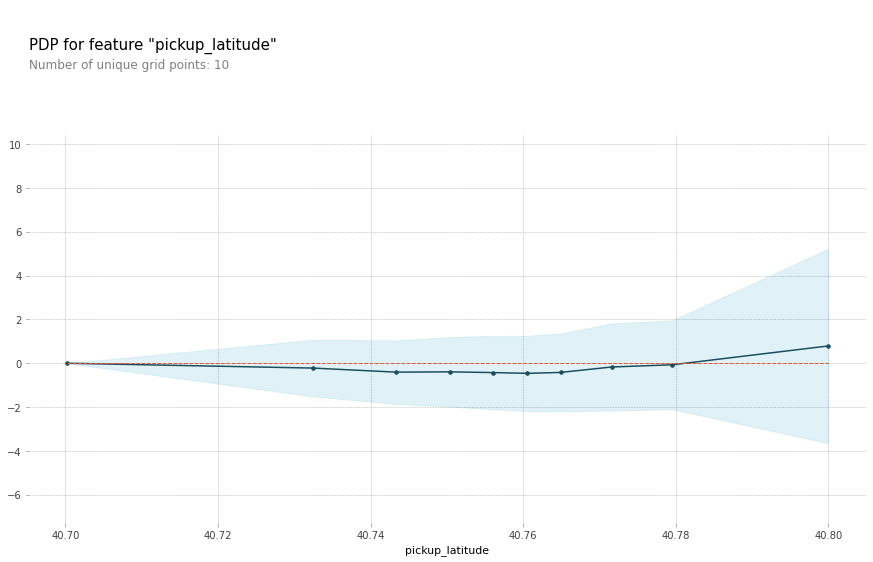

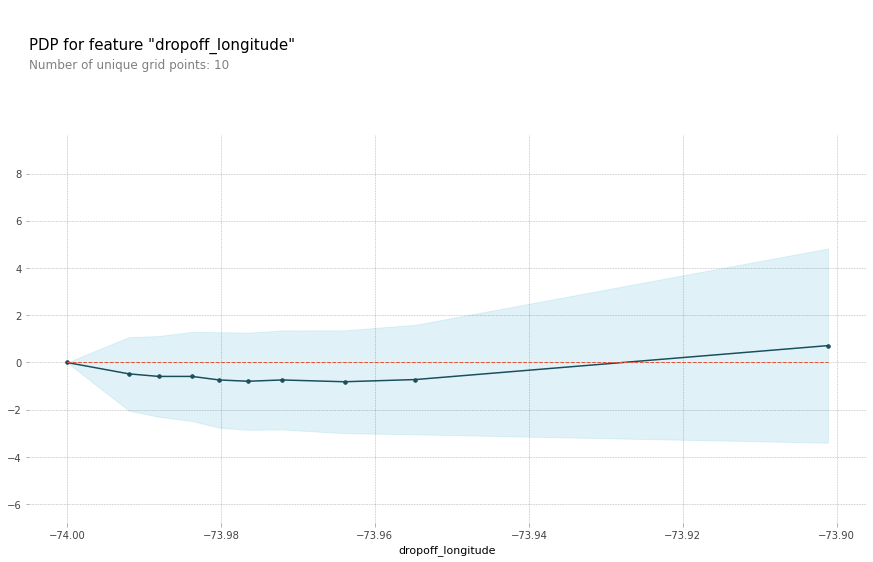

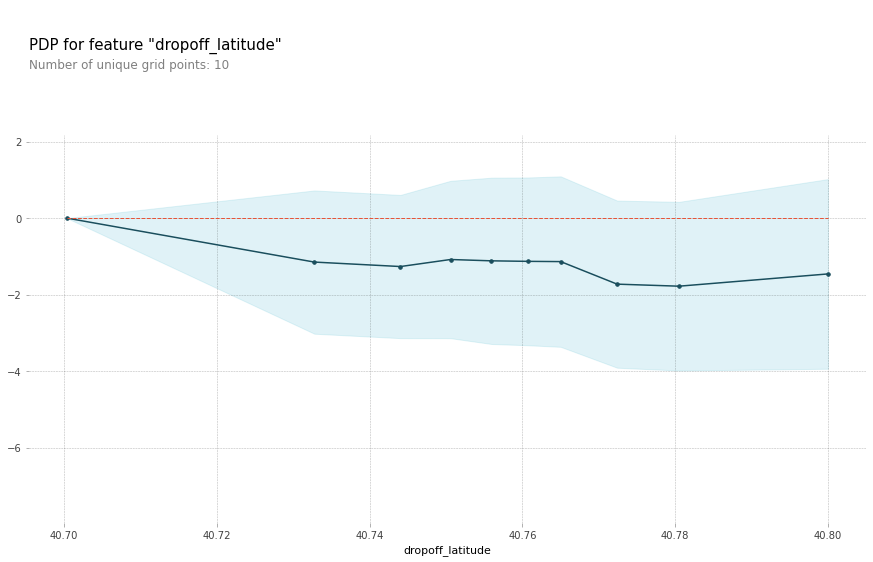

ValueError: ignored

In [55]:
for feat_name in base_features:
  pdp_dist = pdp.pdp_isolate(model = second_model, dataset=new_val_X, model_features = features_2, feature=feat_name)
  pdp.pdp_plot(pdp_dist, feat_name)
  plt.show()

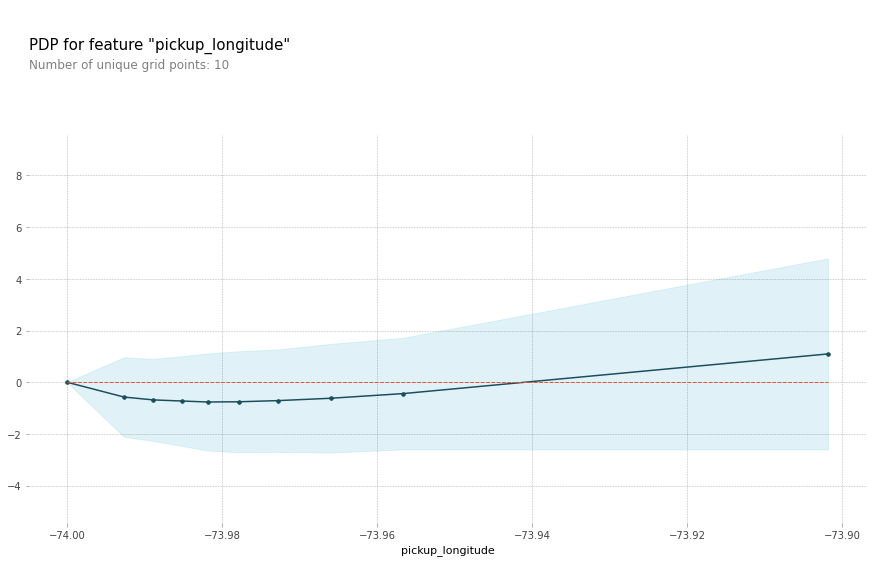

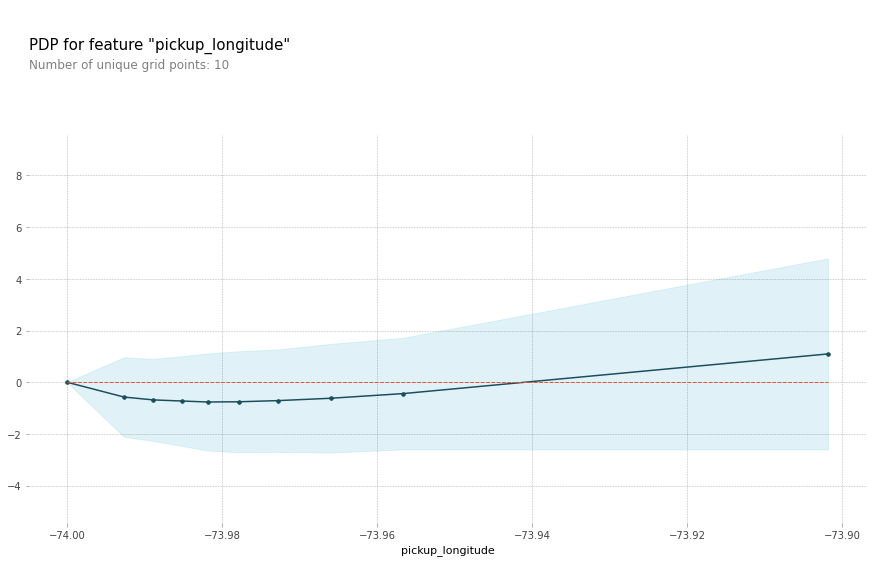

In [56]:
# This is the PDP for pickup_longitude without the absolute difference features. Included here to help compare it to the new PDP you create
feat_name = 'pickup_longitude'
pdp_dist_original = pdp.pdp_isolate(model=second_model, dataset=new_val_X, model_features=features_2, feature=feat_name)

pdp.pdp_plot(pdp_dist_original, feat_name)
plt.show()



# create new features
data['abs_lon_change'] = data['abs_lon_change'] = abs(data.dropoff_longitude - data.pickup_longitude) 
data['abs_lat_change'] = abs(data.dropoff_latitude - data.pickup_latitude)
features_2  = ['pickup_longitude',
               'pickup_latitude',
               'dropoff_longitude',
               'dropoff_latitude',
               'abs_lat_change',
               'abs_lon_change']

X = data[features_2]
new_train_X, new_val_X, new_train_y, new_val_y = train_test_split(X, Y, random_state=1)
second_model = RandomForestRegressor(n_estimators=30, random_state=1).fit(new_train_X, new_train_y)

feat_name = 'pickup_longitude'
pdp_dist = pdp.pdp_isolate(model=second_model, dataset=new_val_X, model_features=features_2, feature=feat_name)

pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

# SHAP Values


In [58]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 29.4 MB/s 


In [59]:
import shap

In [60]:
explainer = shap.TreeExplainer(second_model)

In [62]:
data = pd.read_csv("train1.csv", on_bad_lines='skip')

In [63]:
data.columns

Index(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses', 'race_Caucasian',
       'race_AfricanAmerican', 'gender_Female', 'age_[70-80)', 'age_[60-70)',
       'age_[50-60)', 'age_[80-90)', 'age_[40-50)', 'payer_code_?',
       'payer_code_MC', 'payer_code_HM', 'payer_code_SP', 'payer_code_BC',
       'medical_specialty_?', 'medical_specialty_InternalMedicine',
       'medical_specialty_Emergency/Trauma',
       'medical_specialty_Family/GeneralPractice',
       'medical_specialty_Cardiology', 'diag_1_428', 'diag_1_414',
       'diag_1_786', 'diag_2_276', 'diag_2_428', 'diag_2_250', 'diag_2_427',
       'diag_3_250', 'diag_3_401', 'diag_3_276', 'diag_3_428',
       'max_glu_serum_None', 'A1Cresult_None', 'metformin_No',
       'repaglinide_No', 'nateglinide_No', 'chlorpropamide_No',
       'glimepiride_No', 'acetohexamide_No', 'glipizide_No', 'glyburide_No',
     